<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Label-Encoding" data-toc-modified-id="Label-Encoding-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Label Encoding</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Recommendation" data-toc-modified-id="Recommendation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recommendation</a></span></li></ul></div>

In [212]:
import os
import random
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import copy

tqdm.pandas()
np.set_printoptions(edgeitems=3, infstr="inf", linewidth=75, nanstr="nan", precision=8, suppress=False, threshold=1000, formatter=None)
plt.style.use("dark_background")

C:\Users\82104\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [213]:
# age: (0~4: 0, 5~9: 1, 10~14: 2, ...)
users = pd.read_csv("Datasets/MovieLens 100k/100k_users.csv")
# year: 영화 개봉 연도
movies = pd.read_csv("Datasets/MovieLens 100k/100k_movies.csv")
ratings = pd.read_csv("Datasets/MovieLens 100k/100k_ratings.csv")

data = pd.merge(ratings, users, on="user_id")
data = pd.merge(data, movies, on="item_id")

# Label Encoding

In [214]:
cols = ["user_id", "item_id", "age", "gender", "occupation", "year"] + data.loc[:, "unknown":"Western"].columns.tolist()
for col in cols:
    data[col] = pd.Categorical(data[col])
    data[col] = data[col].cat.codes

- degree $d = 2$인 Factorization Machine의 모델은 다음과 같이 정의됩니다. $d = 2$라는 것은 embedding vectors를 최대 2개 조합하겠다는 의미입니다.
$$
\hat{y}(x):=w_0 + \sum_{i=1}^n w_ix_i + \sum_{i=1}^n\sum_{j=i+1}^n w_{i,j}x_ix_j
$$
- $w_0$: Global Bias
- $n$: The Number of Features
- $w_i$: The Weight of $i$th Feature
- $x_i$: The Value of $i$th Feature of the Sample.
- $w_{i,j}$ : The Interactive Weight of $i$th Feature and $j$th Feature
$$
w_{i,j} := \vec{v_i}\cdot\vec{v_j} = \sum_{f=1}^k v_{i,f}v_{j,f}
$$
- $\vec{v_i}$: The Embedding Vector of $i$th Feature
- `tensorflow.keras.layers.Embedding()`를 사용할 경우
$$
w_0 + \sum_{i=1}^n w_i
$$
- Factorization Machine Part
$$
\sum_{i=1}^n\sum_{j=i+1}^nw_{i,j}x_ix_j = \sum_{i=1}^n\sum_{j=i+1}^n(\vec{v_i}\cdot\vec{v_j})x_ix_j = \sum_{i=1}^n\sum_{j=i+1}^n\sum_{f=1}^k v_{i,f}v_{j,f}x_ix_j
$$
- tf.keras.layers.Embedding() 함수를 사용할 경우 다음과 같이 weights만의 연산으로 표현됩니다.
$$
\sum_{i=1}^n\sum_{j=i+1}^n w_{i,j} = \sum_{i=1}^n\sum_{j=i+1}^n(\vec{v_i}\cdot\vec{v_j}) = \sum_{i=1}^n\sum_{j=i+1}^n\sum_{f=1}^k v_{i,f}v_{j,f}
$$
- 이 식의 시간 복잡도는 $O(kn^2)$입니다.
- 이를 다음과 같이 수정하여 시간 복잡도를 $O(kn)$으로 만들 수 있습니다.
$$
\frac{1}{2}\sum_{f=1}^k\left(\left(\sum_{i=1}^nv_{i,f}\right)^2 - \sum_{i=1}^n{v_{i,f}}^2\right)
$$

# Modeling

In [215]:
# cols = ["user_id", "item_id", "age", "year"]
k = 64
inputs = list()
embedding_mlr_list = list()
embedding_fm_list = list()
for col in cols:
    input_ = Input(shape=(), name=f"Input_{col}")
    inputs.append(input_)
    
    input_dim = data[col].nunique()
    z1 = Embedding(input_dim=input_dim, output_dim=1, name=f"Embedding_1_{col}")(input_)
    embedding_mlr_list.append(z1)

    logits_mlr
    z2 = Embedding(input_dim=input_dim, output_dim=k, name=f"Embedding_{k}_{col}")(input_)
    embedding_fm_list.append(z2)
# Multivariate Linear Regression Part
logits_mlr = tf.Variable((0.,)) + tf.math.add_n(embedding_mlr_list)

# Factorization Machine Part
z = tf.stack(embedding_fm_list, axis=1)
logits_fm = 1/2*tf.math.reduce_sum(tf.math.square(tf.math.reduce_sum(z, axis=1)) - tf.math.reduce_sum(tf.math.square(z), axis=1), axis=1, keepdims=True)

model = Model(inputs=inputs, outputs=logits_mlr + logits_fm, name="movielens100k_fm")

model.compile(optimizer=Adagrad(lr=0.05), loss="mse", metrics=["mse"])
# model.summary()

C:\Users\82104\anaconda3\lib\site-packages\keras\optimizer_v2\adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


# Training

In [216]:
x = data[cols]
y = data[["user_id", "item_id", "rating"]]

x_tr_val, x_te, y_tr_val, y_te = train_test_split(x, y, test_size=0.1, shuffle=True)
x_tr_val = [ser.values for name, ser in x_tr_val.iteritems()]
x_te = [ser.values for name, ser in x_te.iteritems()]
y_tr_val = np.array(y_tr_val["rating"])

es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=2)
model_path = "movielens100k_fm_tensorflow.h5"
mc = ModelCheckpoint(filepath=model_path, monitor="val_mse", mode="auto", verbose=1, save_best_only=True)
hist = model.fit(x=x_tr_val, y=y_tr_val, validation_split=0.2, batch_size=256, epochs=64, verbose=2, shuffle=True, callbacks=[es, mc])

Epoch 1/64

Epoch 00001: val_mse improved from inf to 0.96152, saving model to movielens100k_fm_tensorflow.h5
282/282 - 5s - loss: 2.3649 - mse: 2.3649 - val_loss: 0.9615 - val_mse: 0.9615 - 5s/epoch - 19ms/step
Epoch 2/64

Epoch 00002: val_mse improved from 0.96152 to 0.91152, saving model to movielens100k_fm_tensorflow.h5
282/282 - 3s - loss: 0.9117 - mse: 0.9117 - val_loss: 0.9115 - val_mse: 0.9115 - 3s/epoch - 10ms/step
Epoch 3/64

Epoch 00003: val_mse improved from 0.91152 to 0.90315, saving model to movielens100k_fm_tensorflow.h5
282/282 - 3s - loss: 0.8821 - mse: 0.8821 - val_loss: 0.9031 - val_mse: 0.9031 - 3s/epoch - 9ms/step
Epoch 4/64

Epoch 00004: val_mse improved from 0.90315 to 0.88655, saving model to movielens100k_fm_tensorflow.h5
282/282 - 2s - loss: 0.8694 - mse: 0.8694 - val_loss: 0.8866 - val_mse: 0.8866 - 2s/epoch - 9ms/step
Epoch 5/64

Epoch 00005: val_mse improved from 0.88655 to 0.88051, saving model to movielens100k_fm_tensorflow.h5
282/282 - 3s - loss: 0.8571 

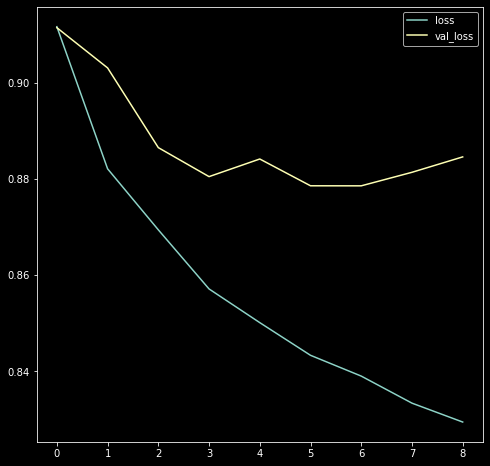

In [217]:
fig, axes = plt.subplots(figsize=(8, 8))
axes.plot(hist.history["loss"][1:], label="loss");
axes.plot(hist.history["val_loss"][1:], label="val_loss");
axes.legend();

# Recommendation

In [225]:
preds = model.predict(x_te)
preds = preds[:, 0]

mape = MeanAbsolutePercentageError()(y_te["rating"], preds).numpy()
print(f"MAPE: {mape:.3}%")

MAPE: 29.1%


In [226]:
res = copy.deepcopy(y_te)
res["pred"] = preds
res = res.rename({"rating":"gt"}, axis=1)

likes_gt = res[res["gt"]>=4.0]
dislikes_gt = res[res["gt"]<=2.0]
likes_pred = res[res["pred"]>=4.0]
dislikes_pred = res[res["pred"]<=2.0]

likes_gby_gt = likes_gt.groupby(["user_id"])["item_id"].apply(set)
likes_gby_pred = likes_pred.groupby(["user_id"])["item_id"].apply(set)

a = 0
b = 0
for i in likes_gby_pred.index:
    if i in likes_gby_gt:
        a += len(likes_gby_gt[i] & likes_gby_pred[i])
        b += len(likes_gby_pred[i])
hit_ratio_dislike = a/b

dislikes_gby_gt = dislikes_gt.groupby(["user_id"])["item_id"].apply(set)
dislikes_gby_pred = dislikes_pred.groupby(["user_id"])["item_id"].apply(set)

a = 0
b = 0
for i in dislikes_gby_pred.index:
    if i in dislikes_gby_gt:
        a += len(dislikes_gby_gt[i] & dislikes_gby_pred[i])
        b += len(dislikes_gby_pred[i])
hit_ratio_like = a/b

print(f"hit_ratio_like: {hit_ratio_like:.1%}")
print(f"hit_ratio_dislike: {hit_ratio_dislike:.1%}")

hit_ratio_like: 75.7%
hit_ratio_dislike: 86.3%
